In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler
import random

import arviz as az

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5, 
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)


In [2]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

### 
Is it necessary to difference time serier data or make it stationary in some way?
###

### Create time series data including a trend and one clearly non-stationary feature

$
Y_t = \alpha + \beta\_trend \cdot t 
$

In [3]:
true_alpha = 1.0
true_beta_regressor = 2.5
true_sigma = 0.1
T = 100
t = np.arange(1, T+1)

linsp1 = np.linspace(0.0, 1.0, num=100)
noise = np.random.normal(loc=0.0, scale=true_sigma, size=100)

### Create data 
data = true_alpha + true_beta_regressor * linsp1 + noise      

date = pd.date_range("1998-01-01", periods=100, freq="QS")

df = pd.DataFrame({"data": data}, index=date)
df['date'] = df.index
df['noise'] = noise
df['true_beta_regressor'] = linsp1
df = df[0:90]
df

,data,date,noise,true_beta_regressor
1998-01-01,0.971386,1998-01-01,-0.028614,0.000000
1998-04-01,0.957148,1998-04-01,-0.068105,0.010101
1998-07-01,0.995975,1998-07-01,-0.054530,0.020202
1998-10-01,1.074810,1998-10-01,-0.000948,0.030303
1999-01-01,1.183675,1999-01-01,0.082665,0.040404
...,...,...,...,...
2019-04-01,3.265636,2019-04-01,0.119171,0.858586
2019-07-01,3.174632,2019-07-01,0.002915,0.868687
2019-10-01,3.250589,2019-10-01,0.053619,0.878788
2020-01-01,3.385978,2020-01-01,0.163755,0.888889


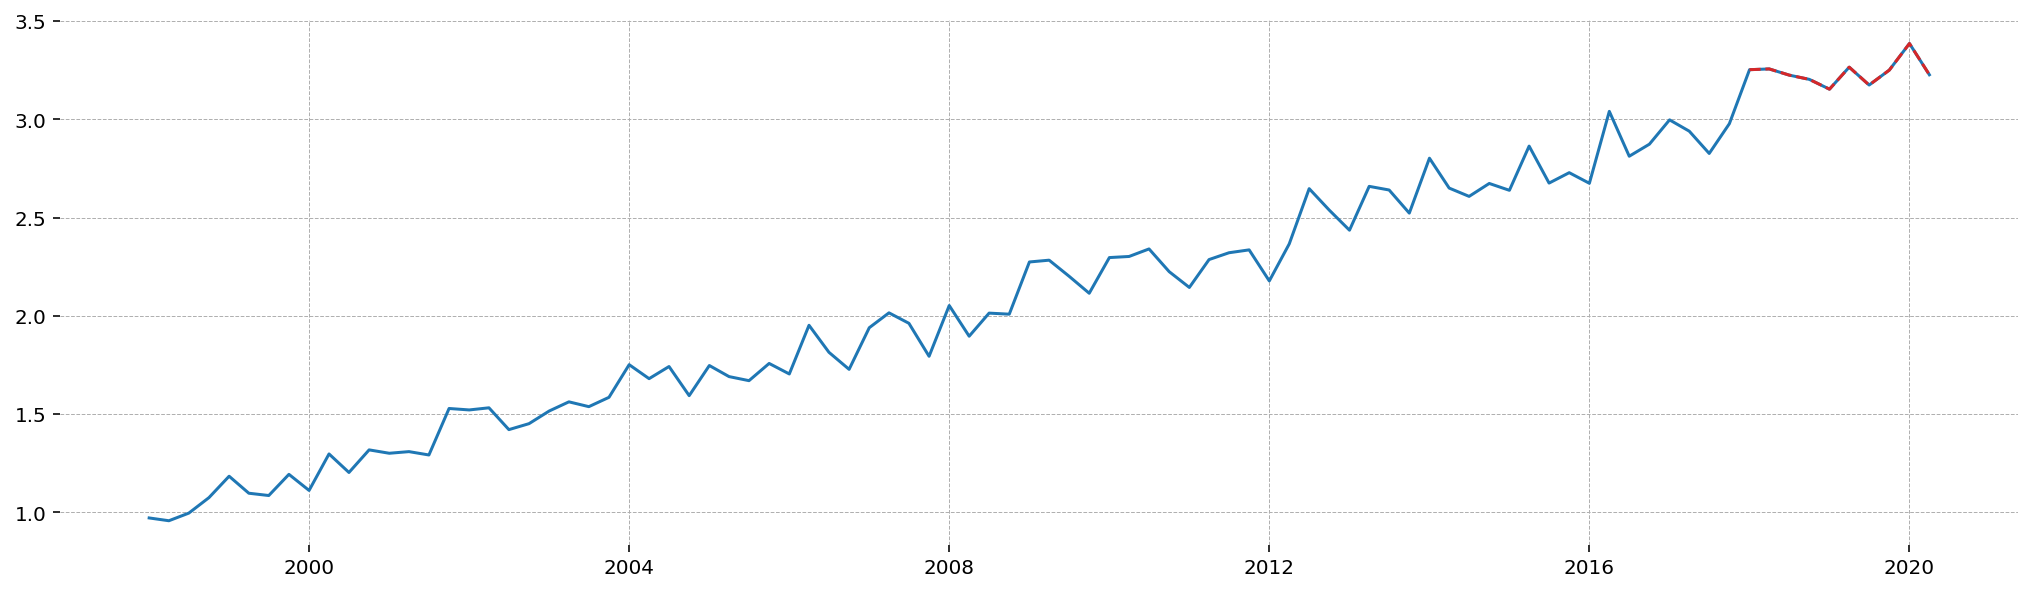

In [4]:
train_data = df[:90]
test_data = df[-10:]

plt.plot(train_data['data'], color='tab:blue')
plt.plot(test_data['data'], ls='--', color='tab:red')

Standardize data

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Sampling: [alpha, sigma, true_beta_regressor, y_hat]
/tmp/ipykernel_27910/1842754495.py:33: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior", num_samples=90)["mu"],


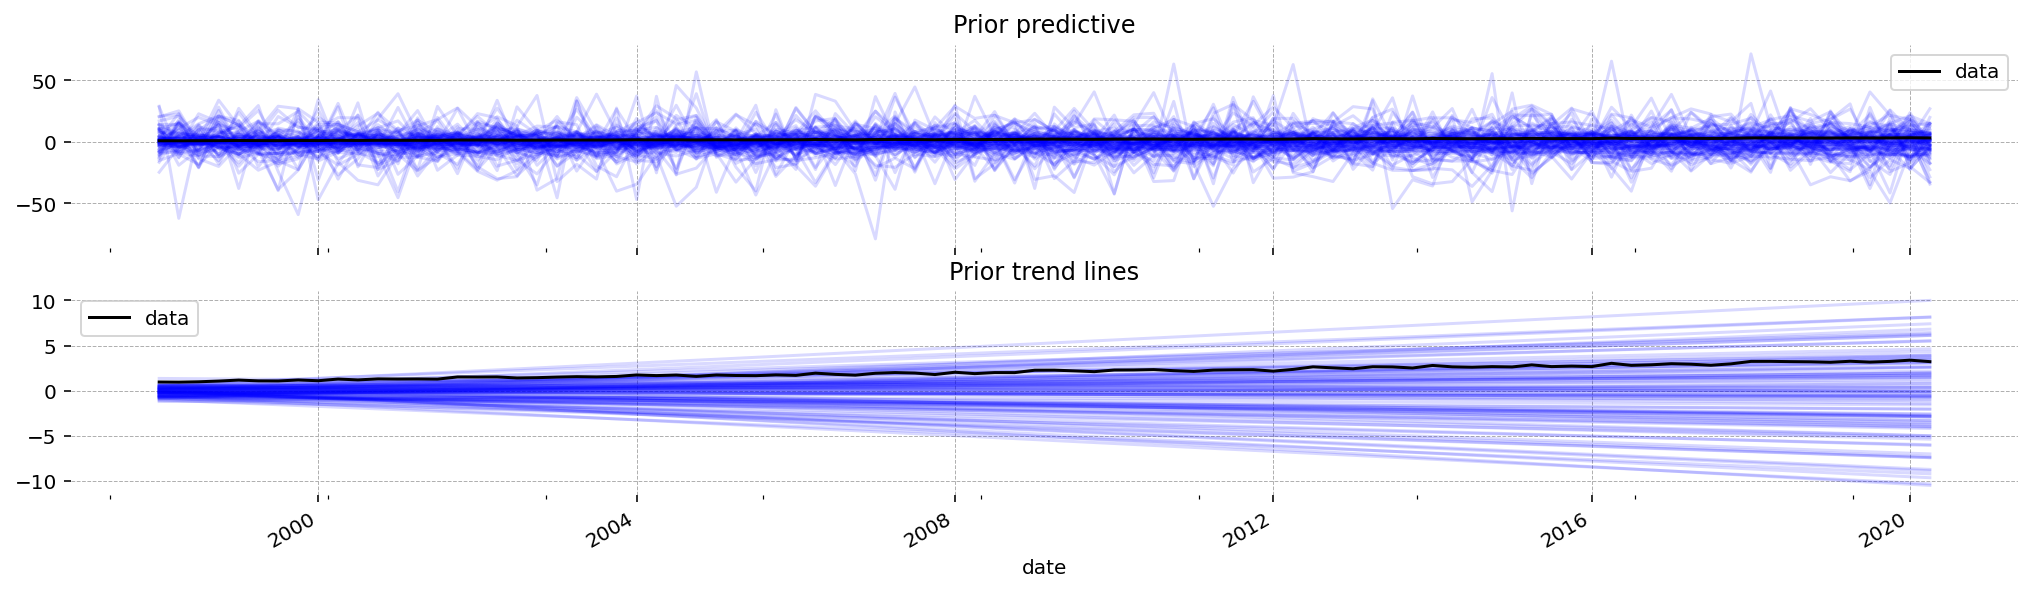

In [5]:
with pm.Model() as det_trend:

    # time
    t_pt = pm.MutableData('t', t[0:90])
    
    # model
    alpha = pm.Normal('alpha', mu = 0, sigma=.5)

    true_beta_regressor = pm.Normal('true_beta_regressor', mu=0, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    mu = pm.Deterministic('mu', alpha + true_beta_regressor * linsp1[0:90])
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=df['data'], shape=t_pt.shape)
    
    linear_prior = pm.sample_prior_predictive()

############################################################################################################

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df['date'],
    az.extract(linear_prior, group="prior_predictive", num_samples=90)["y_hat"],
    color="blue",
    alpha=0.15,
)
df.plot(x='date', y="data", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")


ax[1].plot(
    df['date'],
    az.extract_dataset(linear_prior, group="prior", num_samples=90)["mu"], 
    color="blue",
    alpha=0.15,
)
df.plot(x="date", y="data", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, true_beta_regressor, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 11 seconds.
Sampling: [y_hat]


Output()

/tmp/ipykernel_27910/3467450001.py:10: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=90)["y_hat"],
/tmp/ipykernel_27910/3467450001.py:18: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_trace, group="posterior", num_samples=90)["mu"],


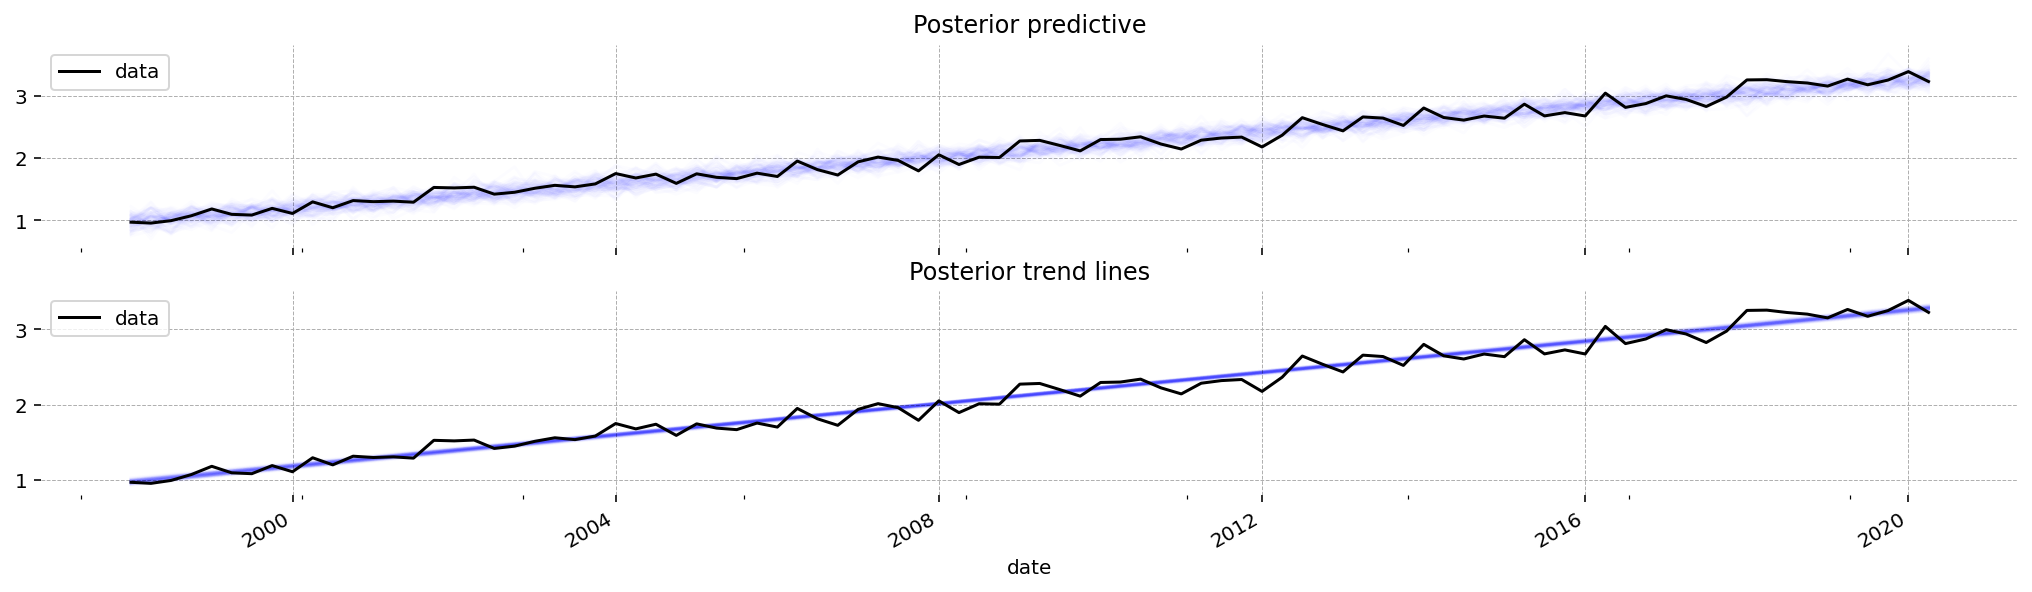

In [6]:
with det_trend:
    linear_trace = pm.sample(return_inferencedata=True, chains=4, draws=10000)
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)

############################################################################################################

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["date"],
    az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=90)["y_hat"],
    color="blue",
    alpha=0.01,
)
df.plot(x="date", y="data", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    df["date"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=90)["mu"],
    color="blue",
    alpha=0.01,
)
df.plot(x="date", y="data", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");


In [7]:
az.summary(linear_trace, round_to=2, var_names=["alpha", "true_beta_regressor", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.98,0.02,0.94,1.02,0.0,0.0,17129.02,19297.29,1.0
true_beta_regressor,2.56,0.04,2.49,2.63,0.0,0.0,17555.87,19487.30,1.0
sigma,0.10,0.01,0.08,0.11,0.0,0.0,23303.73,22526.02,1.0


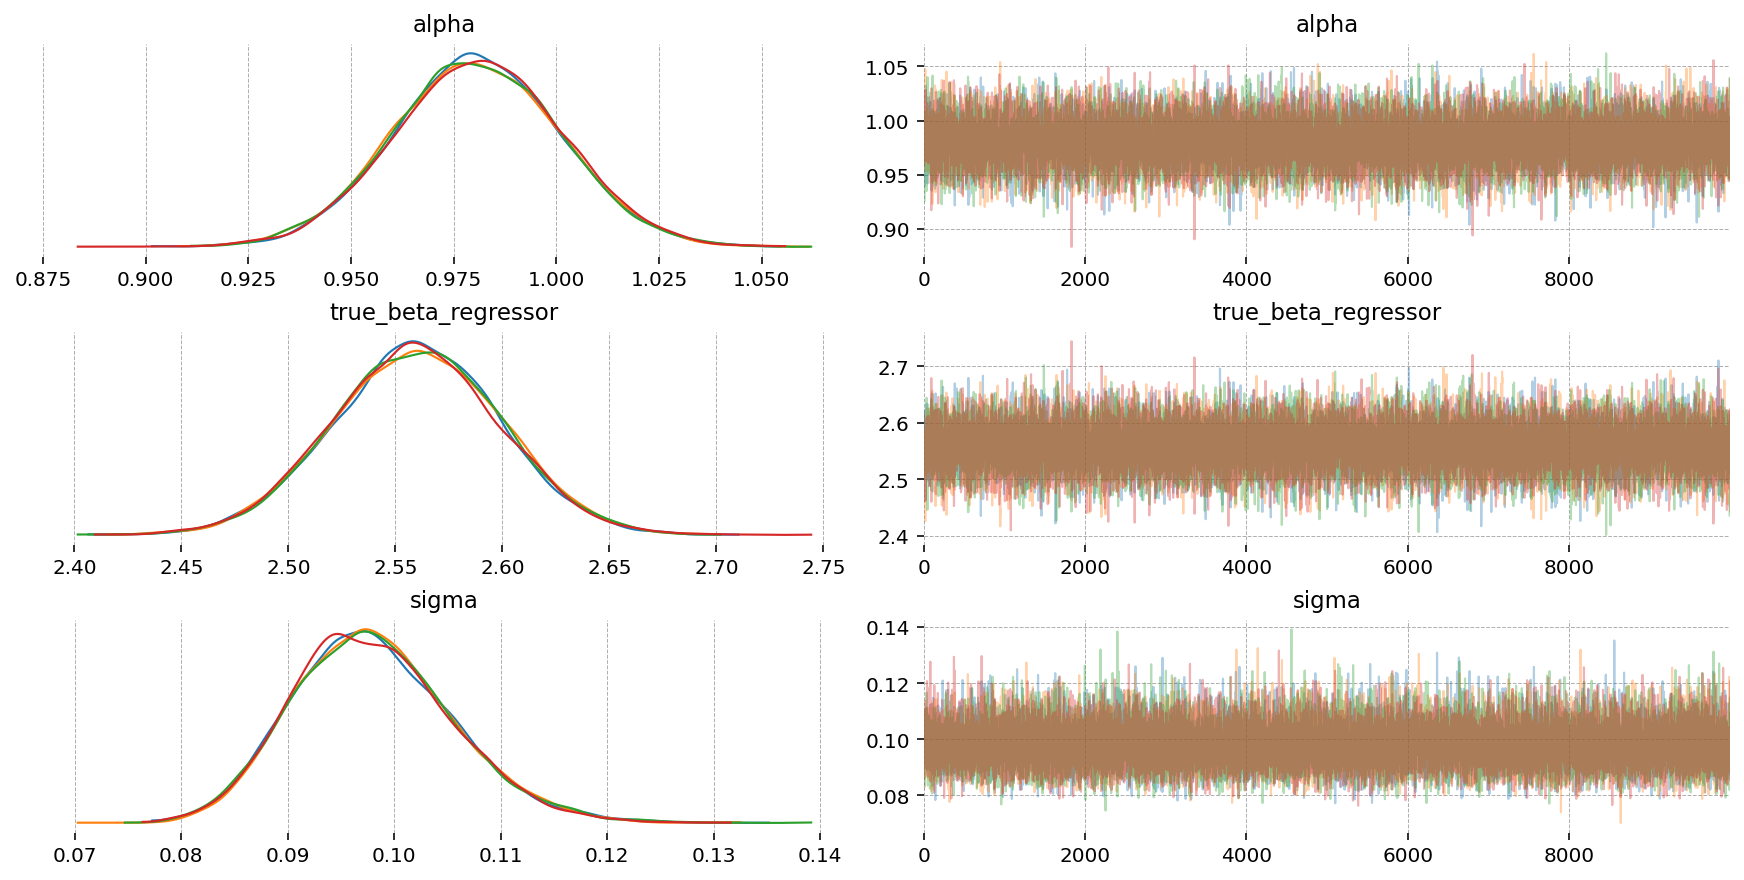

In [8]:
az.plot_trace(linear_trace, var_names=["alpha", "true_beta_regressor", "sigma"], compact=False);

In [9]:
# untransform
# a1 = az.summary(linear_trace, round_to=2, var_names=["true_beta_trend"])["mean"] * y_max/100
# a2 = az.summary(linear_trace, round_to=2, var_names=["true_beta_regressor"])["mean"] * y_max/100
# a1, a2
